# Lesson 4.1 逻辑回归模型构建与多分类学习方法

首先我们来讨论关于逻辑回归的基本原理，当然，在此过程中，我们也将进一步补充机器学习数学理论基础。

逻辑回归的基本原理，从整体上来划分可以分为两个部分，其一是关于模型方程的构建，也就是方程的基本形态，当然也包括模型的基本性质及其结果解读；其二则是模型参数求解，即在构建完模型之后如何利用数学工具求解最佳参数。而这两部分其实都可以从多个角度出发进行理解，基本划分情况如下

* 模型构建部分：可以从广义线性回归(Generalized liner model)+对数几率函数(logit function)角度理解，也可以从随机变量的逻辑斯蒂分布(logistic distribution)角度出发进行理解；

* 参数求解部分：可以借助极大似然估计(Maximum Likelihood Estimate)方法求解，可以借助KL离散度基本理论构建二分类交叉熵损失函数求解。

而无论这些基础理论难易程度如何，其对于此后的机器学习都是至关重要的，因此课上将先从简单角度出发
先构建对逻辑回归基本理论体系的完整认知，然后再补充更加复杂的理论体系，为后续其他算法的学习做铺
垫。

本节我们将先讨论关于逻辑回归的模型构建部分，同时也将讨论模型结果解读和模型可解释性的相关内容，下一节我们将具体讨论关于模型参数求解的相关内容。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

## 一、广义线性模型（Generalized liner model）的基本定义

在Lesso3中我们曾谈到关于线性回归的局限性，这种局限性的根本由模型本身的简单线性结构（自变量加权求和预测因变量）导致的。如果说线性回归是在一个相对严格的条件下建立的简单模型，那么在后续实践应用过程中，人们根据实际情况的不同，在线性回归的基础上又衍生出了种类繁多的线性类摸型。其中，有一类线性模型，是在线性回归基础上，在等号的左边或右边加上了一个函数，从而能够让模型更好的捕捉一般规律，此时该模型就被称为广义线性模型，该函数就被称为联系函数。

广义线性模型的提出初衷上还是为了解决非线性相关的预测问题，例妆如，现在有数据分布如下：

In [2]:
# 数据集特征
np.random.seed(24)
x = np.linspace(0, 4, 20).reshape(-1, 1)
x = np.concatenate((x, np.ones_like(x)), axis=1)
x

array([[0.        , 1.        ],
       [0.21052632, 1.        ],
       [0.42105263, 1.        ],
       [0.63157895, 1.        ],
       [0.84210526, 1.        ],
       [1.05263158, 1.        ],
       [1.26315789, 1.        ],
       [1.47368421, 1.        ],
       [1.68421053, 1.        ],
       [1.89473684, 1.        ],
       [2.10526316, 1.        ],
       [2.31578947, 1.        ],
       [2.52631579, 1.        ],
       [2.73684211, 1.        ],
       [2.94736842, 1.        ],
       [3.15789474, 1.        ],
       [3.36842105, 1.        ],
       [3.57894737, 1.        ],
       [3.78947368, 1.        ],
       [4.        , 1.        ]])

In [3]:
# 数据集标签
y = np.exp(x[:, 0] + 1).reshape(-1, 1)
y

array([[  2.71828183],
       [  3.35525011],
       [  4.1414776 ],
       [  5.11193983],
       [  6.30980809],
       [  7.78836987],
       [  9.61339939],
       [ 11.86608357],
       [ 14.64663368],
       [ 18.07874325],
       [ 22.31509059],
       [ 27.54413077],
       [ 33.99847904],
       [ 41.96525883],
       [ 51.79887449],
       [ 63.93677707],
       [ 78.91892444],
       [ 97.41180148],
       [120.23806881],
       [148.4131591 ]])

此时x和y的真实关系为

$$
y=e^{(x+1)}
$$


但如果也线性方程来进行预测，即：

$$
y=w^T \cdot x+b
$$

当然，我们可以令 $\hat{w}=\left[w_1, w_2, \ldots w_d, b\right]^T$，$\hat{x}=\left[x_1, x_2, \ldots x_d, 1\right]^T$，从而将上述方程改写为：

$$
y=\hat{w}^T \cdot \hat{x}
$$

则模型输出结果为：

In [4]:
np.linalg.lstsq(x, y, rcond=None)[0]

array([[ 30.44214742],
       [-22.37576724]])

即：

$$
y=30.44 x-22.38
$$

则模型预测结果为：

In [5]:
yhat = x[:, 0] * 30.44 - 22.38
yhat

array([-22.38      , -15.97157895,  -9.56315789,  -3.15473684,
         3.25368421,   9.66210526,  16.07052632,  22.47894737,
        28.88736842,  35.29578947,  41.70421053,  48.11263158,
        54.52105263,  60.92947368,  67.33789474,  73.74631579,
        80.15473684,  86.56315789,  92.97157895,  99.38      ])

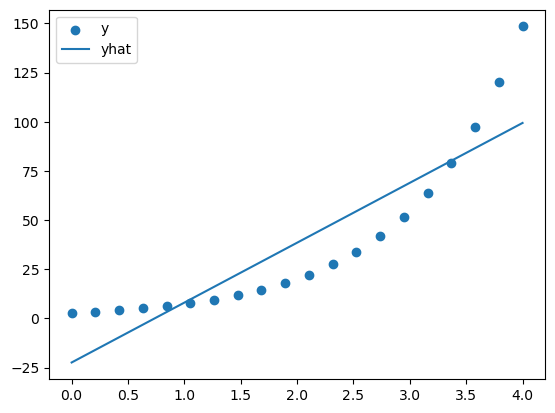

In [6]:
# 观察模型预测值与真实值的差异
plt.scatter(x[:, 0], y, label='y')
plt.plot(x[:, 0], yhat, label='yhat')
plt.legend()
plt.show()


能够发现，线性模型预测结果和真实结果差距较大。但此时如果我们在等号右边加上以为底的指数运算，也就是将线性方程输出结果进行以e为底的指数运算转换之后去预测y，即将方程改写为

$$
y=e^{\left(\hat{w}^T \cdot \hat{x}\right)}
$$

等价于：

$$
\ln y=\hat{w}^T \cdot \hat{x}
$$

即相当于是线性方程输出结果去预测y取以e为底的对数运算之后的结果。此时我们可以带入lny进行建模

In [7]:
np.linalg.lstsq(x, np.log(y), rcond=None)[0]

array([[1.],
       [1.]])

可得到方程

$$
\ln y=x+1
$$

等价于：

$$
y=e^{(x+1)}
$$

即解出原方程

通过上面的过程，我们不难发现，通过在模型左右两端加上某些函数，能够让线性模型也具备捕捉非线性规律的能力。而在上例中，这种捕捉非线性规律的本质，是在方程加入1对数函数之后，能够使得模型的输入空间（特征所在空间）到输出空间（标签所在空间）进行了非线性的函数映射。而这种连接线性方程左右两端、并且实际上能够拓展模型性能的函数，就被称为联系函数，而加入了联系函数的模型也被称为广义线性模型。广义线性模型的一般形式可表示如下：

$$
g(y)=\hat{w}^T \cdot \hat{x}
$$

等价于

$$
y=g^{-1}\left(\hat{w}^T \cdot \hat{x}\right)
$$

其中 $g（·）$ 为联系函数(link function)， $g^{-l}（·）$为联系函数的反函数$ (如 $ y=e^{x} $与 $ln(y)=x $)。而如上例中的情况，也就是当联系函数为自然底数的对数函数时，该模型也被称为对数线性模型(logit linear model),

> 注：般来说广义线性模型要求联系函数必须是单调可微函数。

> 从广义线性模型的角度出发，当联系函数为 $g(x)=x$ 时，$g(y)=y=\hat{w}^T \cdot \hat{x}$，此时就退化成了线性模型。而能够通过联系函数拓展模型捕捉规律的范围，这也就是广义的由来。

> 如果是从数理统计分析角度出发进行建模，对数线性模型建模的基本要求是观测数据服从泊松分布。机器学习建模过程可省略相关检验过程。

## 二、对数几率模型与逻辑回归

逻辑回归也被称为对数几率回归。接下来，我们从广义线性模型角度理解逻辑回归

### 1. 对数几率模型（logit model）

* 几率（odd）与对数几率

几率不是概率，而是一个事件发生与不发生的概率的比值。假设某事件发生的概率为p，则该事件不发生的概率为1-p,该事件的几率为：

$$
\operatorname{odd}(p)=\frac{p}{1-p}
$$

在几率的基础上取（自然底数）对数，则构成该事件的对数几率(logit):

$$
\operatorname{logit}(p)=\ln \frac{p}{1-p}
$$

> 注，logit指的是log unit对数单元的简写，和中文中的“逻辑”一词没有任何关系。对数几率模型也被称为对数单位模型(log unit model)。

* 对数几率模型

如果我们将对数几率看成是一个函数，并将其作为联系函数，即 $g(y)=\ln \frac{y}{1-y}$，则该广义线性模型为：

$$
g(y)=\ln \frac{y}{1-y}=\hat{w}^T \cdot \hat{x}
$$

此时模型就被称为对数几率回归(logistic regression),也被称为逻辑回归。

### 2.逻辑回归与Sigmoid函数

* 对数几率函数与Sigmoid函数

当然，更进一步的，如果我们希望将上述对数几率函数"反解"出来，也就是改写为y=(x)形式，则可参照下述形式：

方程左右两端取自然底数：

$$
\frac{y}{1-y}=e^{\hat{\omega}^T \cdot \hat{x}}
$$

方程左右两端+1可得：

$$
\frac{y+(1-y)}{1-y}=\frac{1}{1-y}=e^{\hat{\omega}^T \cdot \hat{x}}+1
$$

方程左右两端取倒数可得：

$$
1-y=\frac{1}{e^{\hat{w}^T \cdot \hat{x}}+1}
$$

1-方程左右两端可得：

$$
\begin{aligned}
y & =1-\frac{1}{e^{\hat{w}^T \cdot \hat{x}}+1} \\
& =\frac{e^{\hat{\hat{w}^T} \cdot \hat{x}}}{e^{\hat{\hat{w}^T} \cdot \hat{x}}+1} \\
& =\frac{1}{1+e^{-\left(\hat{w}^T \cdot \hat{x}\right)}}=g^{-1}\left(\hat{w}^T \cdot \hat{x}\right)
\end{aligned}
$$

因此，逻辑回归基本模型方程为：

$$
y=\frac{1}{1+e^{-\left(\hat{w}^T \cdot \hat{x}\right)}}
$$

同时我们也能发现，对对数几率函数的反函数为：

$$
f(x)=\frac{1}{1+e^{-x}}
$$

我们可以简单观察该函数的函数图像：

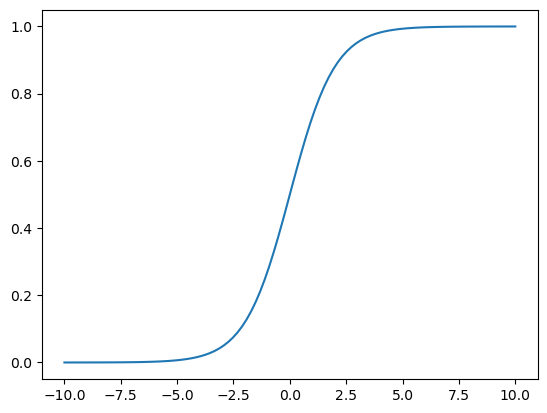

In [8]:
np.random.seed(24)
x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)

能够看出该函数的图像近似S形，这种类似S形的函数，也被称为Sigmoid函数。

注：Sigmoid严格定义是指形如S型的函数，并不是特指某个函数，也就是说，从严格意义来讨论，函数f(x)=中。只能被称为是Sigmoid函数的一种。但实际上，由于该函数是最著名目通用的Sigmoid函数，因此大多数时候，我们在说Sigmoid函数的时候，其实就是在指 $f(x)=\frac{1}{1+e^{-x}}$函数。后续课上对该概念不做区分，Sigmoid函数即指 $ f(x)=\frac{1}{1+e^{-x}}$ 函数。

### 3. Sigmoid函数性质

* Sigmoid函数性质与一阶导函数

对于Sigmoid函数来说，函数是单调递增函数，并且自变量在实数域上取值时，因变量取值范围在（0， 1）之间。并且当自变量取值小于0时，因变量取值小于0.5，当自变量取值大于0时髦，因变量取值大于0.5。

并且，我们简单查看Sigmoid.导函数性质。

令：

$$
\operatorname{Sigmoid}(x)=\frac{1}{1+e^{-x}}
$$

对其求导可得：

$$
\begin{aligned}
\operatorname{Sigmoid}^{\prime}(x) & =\left(\frac{1}{1+e^{-x}}\right)^{\prime} \\
& =\left(\left(1+e^{-x}\right)^{-1}\right)^{\prime} \\
& =(-1)\left(1+e^{-x}\right)^{-2} \cdot\left(e^{-x}\right)^{\prime} \\
& =\left(1+e^{-x}\right)^{-2}\left(e^{-x}\right) \\
& =\frac{e^{-x}}{\left(1+e^{-x}\right)^2} \\
& =\frac{e^{-x}+1-1}{\left(1+e^{-x}\right)^2} \\
& =\frac{1}{1+e^{-x}}-\frac{1}{\left(1+e^{-x}\right)^2} \\
& =\frac{1}{1+e^{-x}}\left(1-\frac{1}{1+e^{-x}}\right) \\
& =\operatorname{Sigmoid}(x)(1-\operatorname{Sigmoid}(x))
\end{aligned}
$$

我们发现，Sigmoid函数的导函数可以简单的用Sigmoid函数本身来表示。接下来我们验证Sigmoid.导函数特性，首先简单定义Sigmoid函数：

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
sigmoid(10)

0.9999546021312976

In [11]:
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

进一步，我们可以绘制Sigmoid导函数图像。

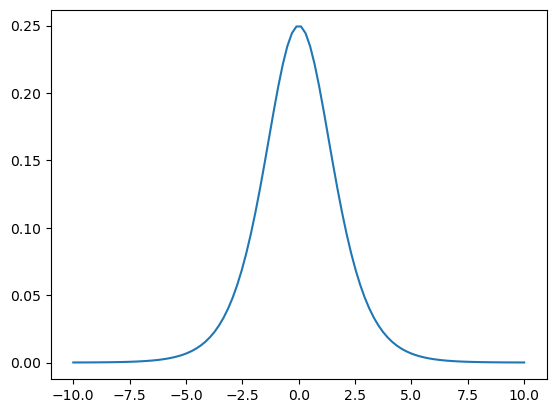

In [12]:
x = np.linspace(-10, 10, 100)
y = sigmoid_derivative(x)
plt.plot(x, y)

我们发现，Sigmoid.导函数在实数域上取值大于0，并且函数图像先递增后递减，并在0点取得最大值。据此我们也可以进一步讨论Sigmoid函数性质：

由于导函数始终大于0，因此Sigmoid函数始终递增，并且导函数在0点取得最大值，因此Sigmoid在0点变化率最快，而在远离零点的点，Sigmoid导函数取值较小，因此该区间Sigmoid函数变化缓慢。该区间也被称为Sigmoid的饱和区间。

当然，如果从简单探索Sigmoid函数的二阶导函数，其实能够发现，x<0时二阶导函数取值大于0（一阶导函数递增），而x>0时二阶导函数小于0（一阶导函数递减）。因此0点其实也是sigmoid函数的拐点。

总结sigmoid函数性质如下：

![Alt text](image-42.png)

## 三、逻辑回归模型输出结果与模型可解释性

从整体情况来看，逻辑回归在经过Sigmoid函数处理之后，是将线性方程输出结果压缩在了0-1之间，用该结果再来进行回归类的连续数值预测肯定是不合适的了。在实际模型应用过程中，逻辑回归主要应用于二分类问题的预测。

> 一般来说，我们会将二分类的类别用一个两个分类水平取值的离散变量来代表，两个分类水平分别为0和1。该离散变量也被称为0-1离散变量。

* 连续型输出结果转化为分类预测结果

对于逻辑回归输出的(0,1)之间的连续型数值，我们只需要确定一个“阈值”，就可以将其转化为二分类的类别判别结果。通常来说，这个阈值是0.5，即以0.5为界，调整模型输出结果：

$$
y_{c l a}=\left\{\begin{array}{l}
0, y<0.5 \\
1, y \geq 0.5
\end{array}\right.
$$

其中，$y_{cla}$ 为类别判别结果，而 $ y$ 为逻辑回归方程输出结果。例如，有简单数据集如下：

![Alt text](image-43.png)

由于只有一个自变量，因此可假设逻辑回归模型如下：

$$
y=\frac{1}{1+e^{x-1}}
$$

带入数据可进一步计算模型输出结果：

In [13]:
x = np.array([2, 0.5]).reshape(-1, 1)

In [14]:
sigmoid(1-x)

array([[0.26894142],
       [0.62245933]])

In [15]:
yhat = sigmoid(1 - x)
yhat

array([[0.26894142],
       [0.62245933]])

In [16]:
ycla = np.zeros_like(yhat)
ycla         #类别判别结果

array([[0.],
       [0.]])

In [17]:
thr = 0.5    #阈值
ycla[yhat > thr] = 1   #类别判别
ycla

array([[0.],
       [1.]])

当然，我们也可以将该过程封装为一个函数：

In [18]:
def logit_cla(yhat, thr = 0.5):
    """逻辑回归类别判别函数
    :param yhat: 预测值
    :param thr: 阈值
    :return: 类别判别结果
    """
    ycla = np.zeros_like(yhat)
    ycla[yhat > thr] = 1
    return ycla

> 关于阈值的选取与0八1分类的类别标记：阈值为人工设置的参数，在没有特殊其他要求下，一般取值为0.5。而关于类别的数值转化，即将哪一类设置为0哪一类设置为1，也完全可以由人工确定，一般来说，我们会将希望被判别或被识别的类设置为1，例如违约客户、确诊病例等。

* 逻辑回归输出结果y是否是概率

决定y是否是概率的核心因素，不是模型本身，而是建模流程。

逻辑斯蒂本身也有对应的概率分布，因此输入的自变量其实是可以视作随机变量的，但前提是需要满足一定的分布要求。如果逻辑回归的建模流程遵照数理统计方法的一般建模流程，即自变量的分布（或者转化之后的分布）满足一定要求（通过检验），则最终模型输出结果就是严格意义上的概率取值。而如果是遵照机器学习建模流程进行建模，在未对自变量进行假设检验下进行模型构建，则由于自变量分布不一定满足条件，因此输出结果不一定为严格意义上的概率。

而课上我们基本都采用机器学习建模流程进行逻辑回归的构建，因此对于模型输出结果y,其实并不一定是严格意义上的概率。不过在目前大多数使用场景中，由于大家希望能够用到模型本身的可解释性，因此还是会将模型结果解读为1发生的概率。尽管这并不是一个严谨的做法，但在机器学习整体的实证”倾向下，只要业务方接受这种做法、并且能够一定程度指导业务，我们就可以将其解读为概率。课上我们将逻辑回归输出结果看成近似概率值。

## 四、多分类学习与多分类逻辑回归

值得一提的是，此前的讨论都是基于二分类问题(0-1分类问题)展开的讨论，而如果要使用逻辑回归解决多分类，则需要额外掌握一些技术手段。

总的来说，如果要使用逻辑回归解决多分类问题，一般来说有两种方法，其一是将逻辑回归模型改为多分类模型形式，其二则是采用通用的多分类学习方法对建模流程进行改造。其中将逻辑回归模型改写成多分类模型形式并不常用并且求解过程非常复杂，包括Scikit-Lear在内，主流的实现多分类逻辑回归的方法都是采用多分类学习方法。所谓多分类学习方法，则指的是将一些二分类学习器(binary classifier)推广到多分类的场景中，该方法属于包括逻辑回归在内所有二分类器都能使用的通用方法。

值得一提的是，对于多分类学习的讨论，也将为后续集成模型的学习做一定的理论铺垫。

* 多分类问题的描述

当离散型标签拥有两个以上分类水平时，即对多个（两个以上）分类进行类别预测的问题，被称为多分类问题。例如有如下四分类问题简单数据集：

![Alt text](image-44.png)

其中index是每条数据编号，labels,是每条数据的标签。

* 多分类问题解决思路

一般来说，用二分类学习器解决多分类问题，基本思想是先拆分后集成，也就是先将数据集进行拆分，然后多个数据集可训练多个模型，然后再对多个模型进行集成。这里所谓集成，指的是使用这多个模型对后续新进来数据的预测方法。

具体来看，依据该思路一般有三种实现策略，分别是”一对一”(One vs Ons,简称OvO)、”一对剩余”（Onevs Rest,简称OvR）和多对多”(Many vs Many,加成MvM),接下来我们逐个讨论。

### 1.OVO策略

OO的拆分策略比较简单，基本过程是将每个类别对应数据集单独拆分成一个子数据集，然后令其两两组合，再来进行模型训练。例如，对于上述四分类数据集，根据标签类别可将其拆分成四个数据集，然后再进行两两组合，总共有6种组合。拆分过程如下所示：

![Alt text](image-45.png)

然后在这6个新和成的数据集上，我们就能训练6个分类器。当然，如果是N分类问题，则需要训练 $ C_N^2=\frac{N(N-1)}{2} $ 一个模型。

* 集成策略

当模型训练完成之后，接下来面对新数据集的预测，可以使用投票法从6个分类器的判别结果中挑选最终判别结果。

![Alt text](image-46.png)

根据少数服从多数的投票法能够得出，某条新数据最终应该属于类别1。

### 2. OVR策略

和OvO的两两组合不同，OvR策略则是每次将一类的样例作为正例、其他所有数据作为反例来进行数据集拆分。对于上述四分类数据集，OV策略最终会将其拆分为4个数据集，基本拆分过程如下：

![Alt text](image-47.png)

此4个数据集就将训练4个分类器。注意，在Ov的划分策略种，是将rst无差别全都划分为负类。当然，如果数据集总共有N个类别，则在进行数据集划分时总共将拆分成N个数据集

* 集成策略

当成，集成策略和划分策略息息相关，对于OvR方法来说，对于新数据的预测，如果仅有一个分类器将其预测为正例，则新数据集属于该类。若有多个分类器将其预测为正例，则根据分类器本身准确率来进行判断，选取准确率更高的那个分类器的判别结果作为新数据的预测结果。

![Alt text](image-48.png)

* OvO和OvR的比较

对于这两种策略来说，尽管OO需要训川练更多的基础分类器，但由于OO中的每个切分出来的数据集都更小，因此基础分类器训练时间也将更短。因此，综合来看在训陈时间开销上，OO往往要小于OV。而在性能方面，大多数情况下二者性能类似。

### 3.MvM策略

相比于OvO和OVR,MM是一种更加复杂的策略。MWM要求同时将若干类化为正类、其他类化为负类，并且要求多次划分，再进行集成。一般来说，通常会采用一种名为"纠错输入码”（Error Correcting Output Codes,简称ECOC）的技术来实现MvM过程。

* 拆分策略

此时对于上述4分类数据集，拆分过程就会变得更加复杂，我们可以任选其中一类作为正类、其余作为负类也可以任选其中两类作为正类、其余作为负数，以此类推。由此则诞生出了非常多种子数据集，对应也将训练非常多个基础分类器。

> 当然，将某一类视作正类和将其余三类视作负类的预测结果相同，对调下预测结果即可，此处不用重复划分。

例如，对于上述4分类数据集，则可有如下划分方式：

![Alt text](image-49.png)

根据上述划分方式，总共将划分 $ C_4^1+C_4^2=10 $ 个数据集，对应构建，对应的我们可以构建10个分类器。不过一般来说对于ECOC来说我们不会如此详尽的对数据集进行划分，而是再上述划分结果中挑选部分数据集进行建摸，例如就挑选上面显式表示的4个数据集来进行建模，即可构建4个分类器。

> 由此我们也不难看出OvR实际上是MM的一种特例。

* 集成策略

接下来我们进行模型集成。值得注意的是，如果是以上述方式划分四个数据集，我们可以将每次划分过程中正例或负例的标签所组成的数组视为每一条数据自己的编码。如下所示：

![Alt text](image-50.png)

同时，我们使用训练好的四个基础分类器对新数据进行预测，也将产生四个结果，而这四个结果也可构成一个四位的新数据的编码。接下来，我们可以计算新数据的编码和上述不同类别编码之间的距离，从而判断新生成数据应该属于哪一类。

![Alt text](image-51.png)

> 不拿发现，如果预测足够准确，编码其实是和类别一对应的。但如果基础分类器预测类别不够准确，编码和类别拼不一定会一对应，有一种三元编码方式，会将这种情况的某个具体编码改为0（纠错输出码），意为停用类。

定义名可夫斯距离函数：

In [19]:
def dist(x, y, cat = 2):
    """闵可夫斯基距离
    param x: 向量1
    param y: 向量2
    param cat: 范数类型
    """
    d1 = np.abs(x - y)
    if x.ndim > 1 or y.ndim > 1:
        res1 = np.power(d1, cat).sum(1)
    else:
        res1 = np.power(d1, cat).sum()
    res = np.power(res1, 1 / cat)
    return res

验证函数性能：

In [21]:
x = np.array([1, 2, 3])
y = np.array([2, 3, 4])

array([1, 2, 3])

In [22]:
dist(x, y)

1.7320508075688772

进行编码距离计算：

In [25]:
# 原类别编码矩阵
code_mat = np.array([[1, -1, 1, -1], 
                     [-1, -1, 1, -1], 
                     [-1, -1, -1, 1],
                     [-1, 1, -1, 1]])

# 预测类别编码矩阵
data_code = np.array([1, -1, 1, 1])

In [26]:
dist(code_mat, data_code)

array([2.        , 2.82842712, 2.82842712, 3.46410162])